In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import copy
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset

In [4]:
with open('A4_640_29x29.npy', 'rb') as f:
    A4_PSFs_raw = np.load(f)
with open('A6_568_29x29.npy', 'rb') as f:
    A6_PSFs_raw = np.load(f)

print(len(A4_PSFs_raw))
print(len(A6_PSFs_raw))

165509
65156


In [53]:
# Reduce the size of the larger dataset (A4-640)
A4_indices = np.random.choice(range(len(A4_PSFs_raw)), len(A6_PSFs_raw))
A4_PSFs_reduced = A4_PSFs_raw[A4_indices]

# Combine, create labels, and reshuffle all
all_data = np.concatenate((A4_PSFs_reduced, A6_PSFs_raw)).astype(np.int32)
labels = np.concatenate((np.zeros(len(A4_PSFs_reduced)), np.ones(len(A6_PSFs_raw))))

random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_indices = np.random.choice(np.arange(len(all_data)), size=len(all_data), replace=False)

In [82]:
class PSFDataset(Dataset):
    def __init__(self, train, split=0.85):
        if train:
            self.images = torch.from_numpy(all_data[all_indices[:int(split*len(all_indices))]]).unsqueeze(1)
            self.labels = torch.from_numpy(labels[all_indices[:int(split*len(all_indices))]]).long()
        else:
            self.images = torch.from_numpy(all_data[all_indices[int(split*len(all_indices)):]]).unsqueeze(1)
            self.labels = torch.from_numpy(labels[all_indices[:int(split*len(all_indices)):]]).long()
        print(self.images.shape)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx].float(), self.labels[idx]

# make training set
PSF_training = PSFDataset(True)
# make test set
PSF_testing = PSFDataset(False)

print(type(PSF_training))
print(all_data.shape)
print(type(all_data))

torch.Size([110765, 1, 29, 29])
torch.Size([19547, 1, 29, 29])
<class '__main__.PSFDataset'>
(130312, 29, 29)
<class 'numpy.ndarray'>


In [66]:
# print(PSF_training[0][0])
print(type(PSF_training[0][1]))
print(PSF_training[0][0][0][0, 0])
print(type(PSF_training[0][0][0][0, 0]))

<class 'numpy.int32'>
tensor(2632, dtype=torch.int32)
<class 'torch.Tensor'>


In [72]:
# model code
class CNN(nn.Module):
    # constructor
    def __init__(self, channel_widths, pooling, nonlinearity=nn.ReLU()):
        super(CNN, self).__init__()
        layers = []
        for i in range(len(channel_widths)-2):
            # convolution layer
            # you can play around with kernel_size, padding, and stride if you like
            # kernel_size is most likely to have an impact
            # arguments are: Conv2d(n_input_channels, n_output_channels, 
            #                       filter_side_length, padding, stride_length)
            layers.append(nn.Conv2d(channel_widths[i], channel_widths[i+1],
                                    kernel_size=5, padding=2, stride=1, bias=False))
            layers.append(nonlinearity) # non-linearity
        # add final layer
        layers.append(nn.Conv2d(channel_widths[-2], channel_widths[-1],
                                    kernel_size=5, padding=2, stride=1, bias=False))
        self.backbone = nn.Sequential(*layers)
        self.global_pooling = pooling # reduce each of the H x W feature maps to a single pooled value
        self.pool_size = pooling.output_size[0]*pooling.output_size[1]
        self.linear = nn.Linear(channel_widths[-1]*self.pool_size, 2)  # score each class to obtain logits
    # forward pass
    def forward(self, x):
        B = x.size(0) # number of input images
        features = self.backbone(x) # get feature maps (B, N_feature_maps, H, W)
        pooled_features = self.global_pooling(features) # (B, N_feature_maps, 1, 1)
        pooled_features = pooled_features.view(B, -1) # (B, N_feature_maps)
        logits = self.linear(pooled_features) # (B, N_classes)
        return logits

In [73]:
def train(model, all_data, training_indices, validation_indices, config, verbose=False):
    # unpack configuration parameters
    lr = config['lr'] # learning rate
    n_epochs = config['n_epochs'] # number of passes (epochs) through the training data
    batch_size = config['batch_size']
    
    # set up optimizer and loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # set up dataloaders
    train_sampler = torch.utils.data.SubsetRandomSampler(training_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(validation_indices)
    trainloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=train_sampler)
    valloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=val_sampler)
    
    # training loop
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0
    best_model = None
    for n in range(n_epochs):
        # set model to training mode (unnecessary for this model, but good practice)
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for images, targets in trainloader:
            optimizer.zero_grad() # zero out gradients
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            loss.backward() # backpropagate to compute gradients
            optimizer.step() # update parameters using stochastic gradient descent
            # update epoch statistics
            epoch_loss += loss.item() # batch loss
            epoch_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item() # number of correct predictions
            
        # validation
        epoch_loss /= len(trainloader)
        epoch_acc /= len(training_indices)
        val_loss, val_acc = validate(model, valloader, criterion)
        val_loss /= len(valloader)
        val_acc /= len(validation_indices)
        
        # log epoch information
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        # save best model, if necessary
        if val_acc > best_val_accuracy:
            best_model = copy.deepcopy(model)
        if verbose and (n+1) % (int(n_epochs/20)) == 0:
            print('Epoch {}/{}: (Train) Loss = {:.4e}, Acc = {:.4f}, (Val) Loss = {:.4e}, Acc = {:.4f}'.format(
                   n+1,
                   n_epochs,
                   epoch_loss,
                   epoch_acc,
                   val_loss,
                   val_acc))
        
        
    return (np.array(train_losses),
            np.array(train_accuracies),
            np.array(val_losses),
            np.array(val_accuracies),
            best_model)
        
def validate(model, dataloader, criterion):
    val_loss = 0
    val_acc = 0
    # set model to eval mode (again, unnecessary here but good practice)
    model.eval()
    # don't compute gradients since we are not updating the model, saves a lot of computation
    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            val_loss += loss.item()
            val_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item()
    return val_loss, val_acc

def test(model, dataset):
    # test best model on withheld test data
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)
            test_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item()
    return test_acc/len(dataset)

In [91]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 5000 # 100 examples per class
N_validation_examples = 5000 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=N_training_examples+N_validation_examples)
training_indices = all_train_indices[:N_training_examples]
validation_indices = all_train_indices[N_training_examples:]

# configuration parameters, you can play around with these
config = {'lr': 1e-8,
          'n_epochs': 200,
          'batch_size': 200}
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 16, 16] # must start with a 1 and be at least length--2
model = CNN(channel_widths, pool_fcn)

# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model,
                                                                   PSF_training,
                                                                   training_indices,
                                                                   validation_indices,
                                                                   config,
                                                                   verbose=verbose)

Epoch 10/200: (Train) Loss = 2.1230e+02, Acc = 0.5264, (Val) Loss = 1.9464e+02, Acc = 0.5340
Epoch 20/200: (Train) Loss = 1.7447e+02, Acc = 0.5820, (Val) Loss = 1.6188e+02, Acc = 0.5892
Epoch 30/200: (Train) Loss = 1.5545e+02, Acc = 0.6140, (Val) Loss = 1.4536e+02, Acc = 0.6234
Epoch 40/200: (Train) Loss = 1.4435e+02, Acc = 0.6386, (Val) Loss = 1.3654e+02, Acc = 0.6440
Epoch 50/200: (Train) Loss = 1.3711e+02, Acc = 0.6504, (Val) Loss = 1.3110e+02, Acc = 0.6568
Epoch 60/200: (Train) Loss = 1.3146e+02, Acc = 0.6632, (Val) Loss = 1.2679e+02, Acc = 0.6650
Epoch 70/200: (Train) Loss = 1.2703e+02, Acc = 0.6720, (Val) Loss = 1.2352e+02, Acc = 0.6716
Epoch 80/200: (Train) Loss = 1.2332e+02, Acc = 0.6796, (Val) Loss = 1.2083e+02, Acc = 0.6756
Epoch 90/200: (Train) Loss = 1.2021e+02, Acc = 0.6846, (Val) Loss = 1.1844e+02, Acc = 0.6798
Epoch 100/200: (Train) Loss = 1.1751e+02, Acc = 0.6866, (Val) Loss = 1.1645e+02, Acc = 0.6852
Epoch 110/200: (Train) Loss = 1.1510e+02, Acc = 0.6922, (Val) Loss = 

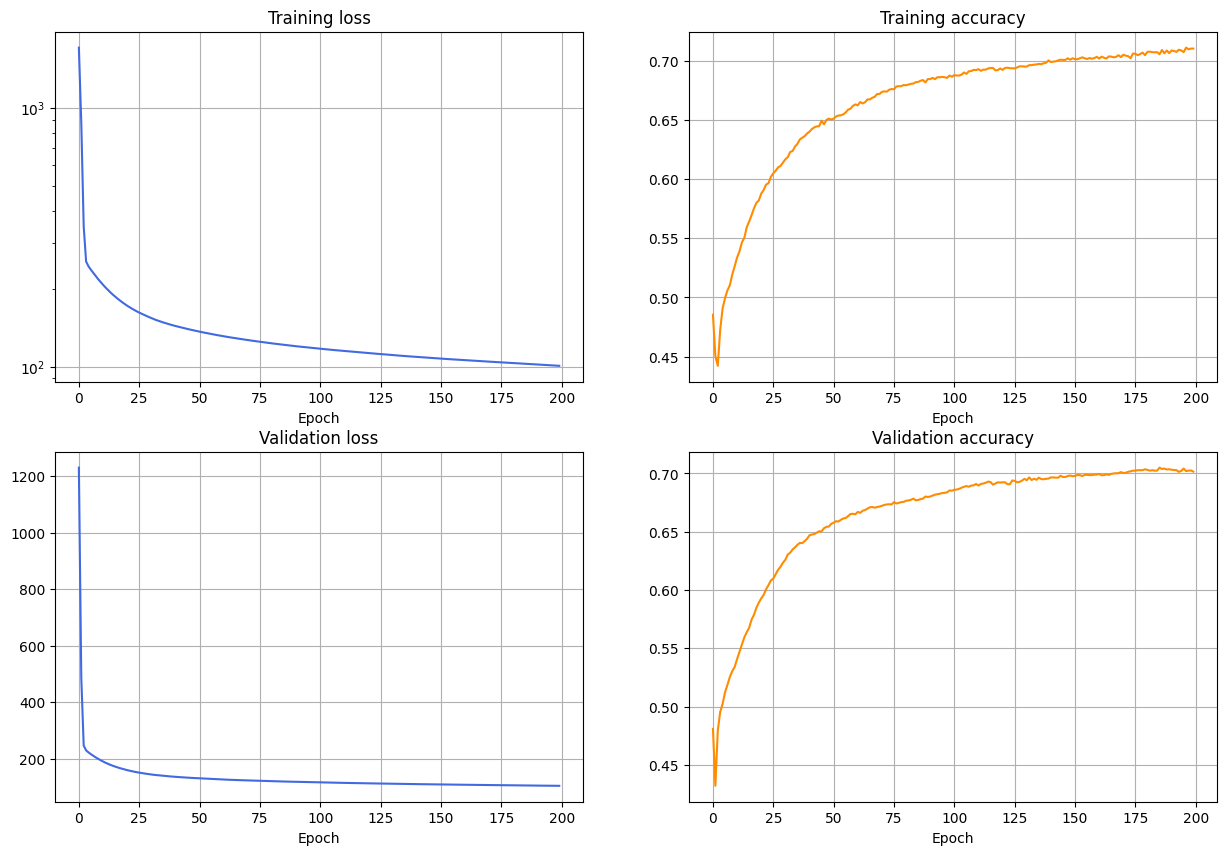

In [92]:
# plot training/validation loss and accuracy over training time
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.semilogy(train_losses, color='royalblue')
plt.xlabel('Epoch')
plt.title('Training loss')
plt.grid(True)
plt.subplot(222)
plt.plot(train_accs, color='darkorange')
plt.xlabel('Epoch')
plt.title('Training accuracy')
plt.grid(True)
plt.subplot(223)
plt.plot(val_losses, color='royalblue')
plt.xlabel('Epoch')
plt.title('Validation loss')
plt.grid(True)
plt.subplot(224)
plt.plot(val_accs, color='darkorange')
plt.xlabel('Epoch')
plt.title('Validation accuracy')
plt.grid(True)

In [96]:
print(test(best_model, PSF_testing))

0.4998721031360311
